## 99,3% accuracy on MNIST using Keras and Tensorflow (60 epochs)

In this project, I created Convolutional Neural Network to achieve high accuracy in [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database). The goal was to get above 99% accuracy in a modest amount of training time/epochs and to keep network relatively simple (~300k parameters).

Importing all the dependancies

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import helper

# Keras dependancies
import keras
from keras.optimizers import Adam, RMSprop
from keras.preprocessing import image
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras import backend as K
K.set_image_dim_ordering('tf')

from keras.callbacks import ReduceLROnPlateau

Using TensorFlow backend.


In [2]:
model_path = 'models/'

import os
if not os.path.exists(model_path):
    os.makedirs(model_path)

### Importing MNIST dataset:

In [3]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("MNIST shapes")
print("x_train :", x_train.shape)
print("y_train :", y_train.shape)
print("x_test  :", x_test.shape)
print("y_test  :", y_test.shape)

MNIST shapes
x_train : (60000, 28, 28)
y_train : (60000,)
x_test  : (10000, 28, 28)
y_test  : (10000,)


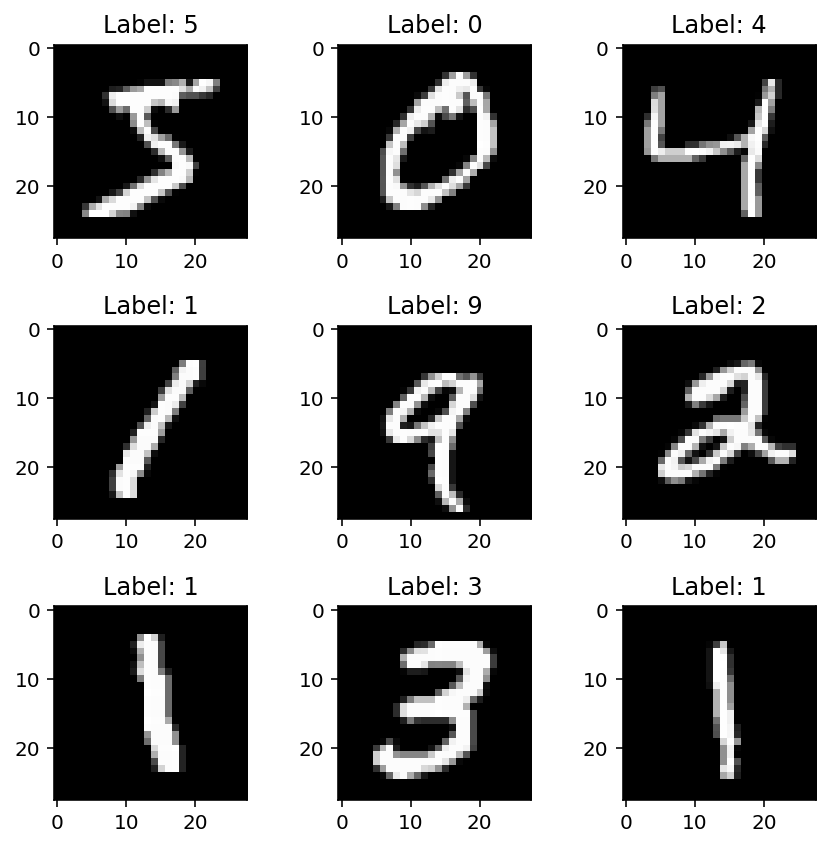

In [4]:
helper.display_nine_examples(x_train, y_train)

In [5]:
# preserving old shape
y_val_train = y_train
y_val_test = y_test
# reshaping for TensorFlow - 1 dimension for greyscale, 3 for RGB
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)
print("x_train :", x_train.shape)
print("x_test  :", x_test.shape)  

x_train : (60000, 28, 28, 1)
x_test  : (10000, 28, 28, 1)


In [6]:
# Before one-hot
y_train[0:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

### [One-hot encoding](https://en.wikipedia.org/wiki/One-hot) the dataset:

In [7]:
# One-hot encoding labels for the softmax output layer
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [8]:
# After one-hot
y_train[0:10]

array([[ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]])

In [9]:
# Input normalization
mean = x_train.mean().astype(np.float32)
std_dev = x_train.std().astype(np.float32)

def normalize_input(x): 
    return (x - mean) / std_dev

### Simple linear model using for testing (orders of magnitude faster than the final model):

In [10]:
def get_linear_model():
    model = Sequential()
    model.add(Lambda(normalize_input, input_shape=(28,28,1)))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    model.compile(Adam(), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

### Actual CNN:

Model Structure:

- 28x28x1 (Greyscale pictures) input, normalised

- Two [convolutional layers](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/), 32 neurons, Kernel size 3x3 and 3x3, [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) activation

- [Max pooling](https://www.quora.com/What-is-max-pooling-in-convolutional-neural-networks) (2 by 2)

- Two convolutional layers, 64 neurons, Kernel size 3 by 3, ReLU activation

- Another max pooling (2 by 2)

- [Flattening](https://www.quora.com/What-is-the-meaning-of-flattening-step-in-a-convolutional-neural-network) layer

- Fully connected layer, 256 neurons, ReLU activation

- Dropout 50%

- Final fully connected layer, 10 output neurons, [Softmax](https://en.wikipedia.org/wiki/Softmax_function) activation

- The network uses [Adam](https://arxiv.org/abs/1412.6980) optimizer

In [11]:
def get_model():
    model = Sequential()
    model.add(Lambda(normalize_input, input_shape=(28,28,1)))
    model.add(Conv2D(32,(3,3), activation='relu'))
    model.add(Conv2D(32,(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64,(3,3), activation='relu'))
    model.add(Conv2D(64,(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    model.compile(Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [12]:
model = get_model()
# model = get_linear_model() # simple model used for testing

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
__________

In [14]:
# Data augmentation to prevent overfitting
gen = image.ImageDataGenerator(rotation_range=10,
                               width_shift_range=0.1, 
                               shear_range=0.1,
                               height_shift_range=0.1, 
                               zoom_range=0.1)

### Visualising data augmentation:

/usr/local/lib/python3.6/site-packages/keras/preprocessing/image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (9, 28, 28, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


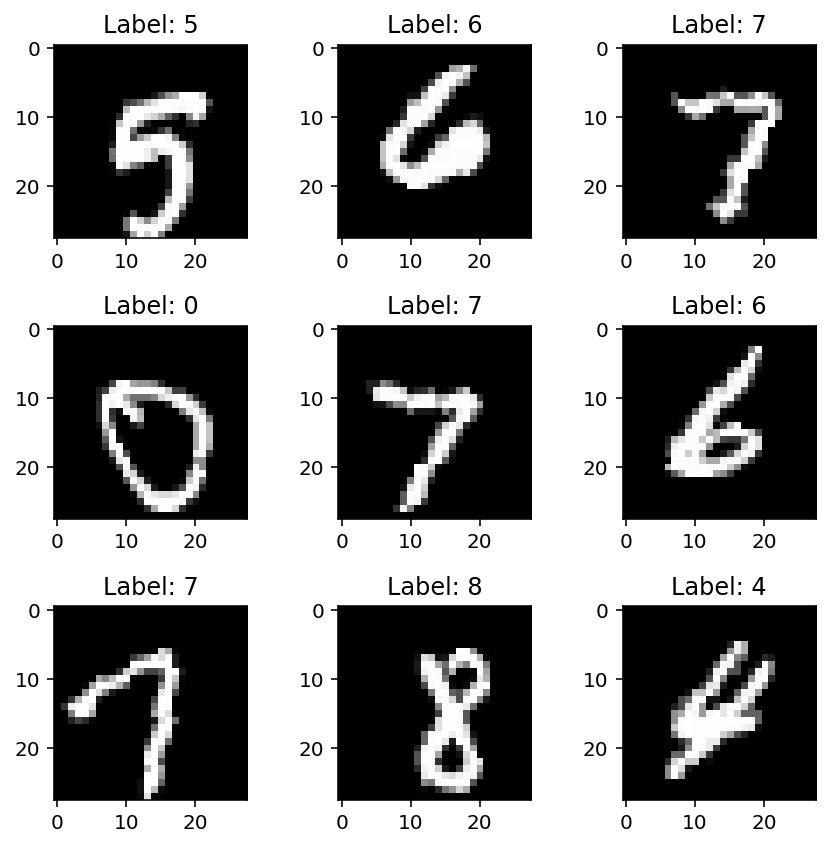

In [15]:
helper.display_data_augmentation(gen, x_test, y_val_test)

In [16]:
batch_size = 128
batches = gen.flow(x_train, y_train, batch_size)
test_batches = gen.flow(x_test, y_test, batch_size)
steps_per_epoch = batches.n // batch_size
validation_steps = test_batches.n // batch_size

In [17]:
global_history = model.fit_generator(batches,
                                     steps_per_epoch=steps_per_epoch,
                                     epochs=1,
                                     validation_data=test_batches,
                                     validation_steps=validation_steps,
                                     verbose=1)

Epoch 1/1
468/468 [==============================] - 14s - loss: 0.3683 - acc: 0.8834 - val_loss: 0.0873 - val_acc: 0.9708


In [18]:
model.save_weights(model_path+'mnist_epoch1.h5')

In [19]:
current_history = model.fit_generator(batches,
                                      steps_per_epoch=steps_per_epoch,
                                      epochs=4,
                                      validation_data=test_batches,
                                      validation_steps=validation_steps,
                                      verbose=1)

global_history = helper.append_global_history(global_history, current_history)

Epoch 1/4
468/468 [==============================] - 13s - loss: 0.1156 - acc: 0.9652 - val_loss: 0.0549 - val_acc: 0.9814
Epoch 2/4
468/468 [==============================] - 13s - loss: 0.0835 - acc: 0.9749 - val_loss: 0.0528 - val_acc: 0.9833
Epoch 3/4
468/468 [==============================] - 13s - loss: 0.0701 - acc: 0.9791 - val_loss: 0.0424 - val_acc: 0.9864
Epoch 4/4
468/468 [==============================] - 13s - loss: 0.0632 - acc: 0.9817 - val_loss: 0.0354 - val_acc: 0.9894


In [20]:
model.save_weights(model_path+'mnist_epoch5.h5')

In [21]:
current_history = model.fit_generator(batches,
                                      steps_per_epoch=steps_per_epoch,
                                      epochs=5,
                                      validation_data=test_batches,
                                      validation_steps=validation_steps,
                                      verbose=1)

global_history = helper.append_global_history(global_history, current_history)

Epoch 1/5
468/468 [==============================] - 13s - loss: 0.0555 - acc: 0.9834 - val_loss: 0.0365 - val_acc: 0.9872
Epoch 2/5
468/468 [==============================] - 13s - loss: 0.0523 - acc: 0.9844 - val_loss: 0.0382 - val_acc: 0.9879
Epoch 3/5
468/468 [==============================] - 13s - loss: 0.0491 - acc: 0.9857 - val_loss: 0.0329 - val_acc: 0.9896
Epoch 4/5
468/468 [==============================] - 13s - loss: 0.0449 - acc: 0.9867 - val_loss: 0.0310 - val_acc: 0.9898
Epoch 5/5
468/468 [==============================] - 13s - loss: 0.0458 - acc: 0.9868 - val_loss: 0.0317 - val_acc: 0.9907


In [22]:
model.save_weights(model_path+'mnist_epoch10.h5')

In [23]:
current_history = model.fit_generator(batches,
                                      steps_per_epoch=steps_per_epoch,
                                      epochs=10,
                                      validation_data=test_batches,
                                      validation_steps=validation_steps,
                                      verbose=1)

global_history = helper.append_global_history(global_history, current_history)

Epoch 1/10
468/468 [==============================] - 13s - loss: 0.0400 - acc: 0.9882 - val_loss: 0.0263 - val_acc: 0.9921
Epoch 2/10
468/468 [==============================] - 13s - loss: 0.0423 - acc: 0.9877 - val_loss: 0.0264 - val_acc: 0.9916
Epoch 3/10
468/468 [==============================] - 13s - loss: 0.0393 - acc: 0.9885 - val_loss: 0.0318 - val_acc: 0.9906
Epoch 4/10
468/468 [==============================] - 13s - loss: 0.0387 - acc: 0.9890 - val_loss: 0.0233 - val_acc: 0.9917
Epoch 5/10
468/468 [==============================] - 13s - loss: 0.0360 - acc: 0.9894 - val_loss: 0.0231 - val_acc: 0.9925
Epoch 6/10
468/468 [==============================] - 13s - loss: 0.0361 - acc: 0.9894 - val_loss: 0.0256 - val_acc: 0.9917
Epoch 7/10
468/468 [==============================] - 13s - loss: 0.0326 - acc: 0.9900 - val_loss: 0.0288 - val_acc: 0.9913
Epoch 8/10
468/468 [==============================] - 13s - loss: 0.0339 - acc: 0.9898 - val_loss: 0.0312 - val_acc: 0.9909
Epoch 9/

In [24]:
model.save_weights(model_path+'mnist_epoch20.h5')

In [25]:
current_history = model.fit_generator(batches,
                                      steps_per_epoch=steps_per_epoch,
                                      epochs=10,
                                      validation_data=test_batches,
                                      validation_steps=validation_steps,
                                      verbose=1)

global_history = helper.append_global_history(global_history, current_history)

Epoch 1/10
468/468 [==============================] - 13s - loss: 0.0312 - acc: 0.9909 - val_loss: 0.0214 - val_acc: 0.9928
Epoch 2/10
468/468 [==============================] - 13s - loss: 0.0321 - acc: 0.9903 - val_loss: 0.0225 - val_acc: 0.9925
Epoch 3/10
468/468 [==============================] - 13s - loss: 0.0300 - acc: 0.9907 - val_loss: 0.0289 - val_acc: 0.9912
Epoch 4/10
468/468 [==============================] - 13s - loss: 0.0299 - acc: 0.9908 - val_loss: 0.0253 - val_acc: 0.9922
Epoch 5/10
468/468 [==============================] - 13s - loss: 0.0288 - acc: 0.9913 - val_loss: 0.0177 - val_acc: 0.9942
Epoch 6/10
468/468 [==============================] - 13s - loss: 0.0269 - acc: 0.9916 - val_loss: 0.0252 - val_acc: 0.9922
Epoch 7/10
468/468 [==============================] - 13s - loss: 0.0279 - acc: 0.9915 - val_loss: 0.0231 - val_acc: 0.9931
Epoch 8/10
468/468 [==============================] - 13s - loss: 0.0282 - acc: 0.9917 - val_loss: 0.0222 - val_acc: 0.9932
Epoch 9/

In [26]:
model.save_weights(model_path+'mnist_epoch30.h5')

In [27]:
current_history = model.fit_generator(batches,
                                      steps_per_epoch=steps_per_epoch,
                                      epochs=10,
                                      validation_data=test_batches,
                                      validation_steps=validation_steps,
                                      verbose=1)

global_history = helper.append_global_history(global_history, current_history)

Epoch 1/10
468/468 [==============================] - 13s - loss: 0.0265 - acc: 0.9921 - val_loss: 0.0237 - val_acc: 0.9921
Epoch 2/10
468/468 [==============================] - 13s - loss: 0.0262 - acc: 0.9923 - val_loss: 0.0212 - val_acc: 0.9934
Epoch 3/10
468/468 [==============================] - 13s - loss: 0.0241 - acc: 0.9925 - val_loss: 0.0261 - val_acc: 0.9917
Epoch 4/10
468/468 [==============================] - 13s - loss: 0.0262 - acc: 0.9919 - val_loss: 0.0271 - val_acc: 0.9918
Epoch 5/10
468/468 [==============================] - 13s - loss: 0.0248 - acc: 0.9922 - val_loss: 0.0220 - val_acc: 0.9935
Epoch 6/10
468/468 [==============================] - 13s - loss: 0.0212 - acc: 0.9931 - val_loss: 0.0263 - val_acc: 0.9922
Epoch 7/10
468/468 [==============================] - 13s - loss: 0.0246 - acc: 0.9924 - val_loss: 0.0215 - val_acc: 0.9935
Epoch 8/10
468/468 [==============================] - 13s - loss: 0.0216 - acc: 0.9934 - val_loss: 0.0221 - val_acc: 0.9933
Epoch 9/

In [28]:
model.save_weights(model_path+'mnist_epoch40.h5')

In [29]:
current_history = model.fit_generator(batches,
                                      steps_per_epoch=steps_per_epoch,
                                      epochs=10,
                                      validation_data=test_batches,
                                      validation_steps=validation_steps,
                                      verbose=1)

global_history = helper.append_global_history(global_history, current_history)

Epoch 1/10
468/468 [==============================] - 13s - loss: 0.0244 - acc: 0.9928 - val_loss: 0.0216 - val_acc: 0.9934
Epoch 2/10
468/468 [==============================] - 13s - loss: 0.0238 - acc: 0.9929 - val_loss: 0.0214 - val_acc: 0.9928
Epoch 3/10
468/468 [==============================] - 13s - loss: 0.0215 - acc: 0.9934 - val_loss: 0.0237 - val_acc: 0.9928
Epoch 4/10
468/468 [==============================] - 13s - loss: 0.0222 - acc: 0.9934 - val_loss: 0.0235 - val_acc: 0.9928
Epoch 5/10
468/468 [==============================] - 13s - loss: 0.0229 - acc: 0.9934 - val_loss: 0.0240 - val_acc: 0.9936
Epoch 6/10
468/468 [==============================] - 13s - loss: 0.0225 - acc: 0.9931 - val_loss: 0.0230 - val_acc: 0.9925
Epoch 7/10
468/468 [==============================] - 13s - loss: 0.0218 - acc: 0.9933 - val_loss: 0.0264 - val_acc: 0.9924
Epoch 8/10
468/468 [==============================] - 13s - loss: 0.0222 - acc: 0.9938 - val_loss: 0.0231 - val_acc: 0.9933
Epoch 9/

In [30]:
model.save_weights(model_path+'mnist_epoch50.h5')

In [31]:
current_history = model.fit_generator(batches,
                                      steps_per_epoch=steps_per_epoch,
                                      epochs=10,
                                      validation_data=test_batches,
                                      validation_steps=validation_steps,
                                      verbose=1)

global_history = helper.append_global_history(global_history, current_history)

Epoch 1/10
468/468 [==============================] - 14s - loss: 0.0210 - acc: 0.9938 - val_loss: 0.0207 - val_acc: 0.9938
Epoch 2/10
468/468 [==============================] - 13s - loss: 0.0219 - acc: 0.9932 - val_loss: 0.0221 - val_acc: 0.9936
Epoch 3/10
468/468 [==============================] - 13s - loss: 0.0209 - acc: 0.9934 - val_loss: 0.0245 - val_acc: 0.9920
Epoch 4/10
468/468 [==============================] - 13s - loss: 0.0198 - acc: 0.9939 - val_loss: 0.0233 - val_acc: 0.9935
Epoch 5/10
468/468 [==============================] - 13s - loss: 0.0214 - acc: 0.9939 - val_loss: 0.0200 - val_acc: 0.9941
Epoch 6/10
468/468 [==============================] - 13s - loss: 0.0213 - acc: 0.9935 - val_loss: 0.0204 - val_acc: 0.9951
Epoch 7/10
468/468 [==============================] - 13s - loss: 0.0209 - acc: 0.9939 - val_loss: 0.0220 - val_acc: 0.9938
Epoch 8/10
468/468 [==============================] - 13s - loss: 0.0180 - acc: 0.9944 - val_loss: 0.0267 - val_acc: 0.9929
Epoch 9/

In [32]:
model.save_weights(model_path+'mnist_epoch60.h5')

In [33]:
model.load_weights(model_path+'mnist_epoch60.h5')

### Testing accuracy on test dataset:

In [34]:
score = model.evaluate(x_test, y_test, verbose=1)
print("\n")
print("Accuracy :", score[1])
print("Loss     :", score[0])

 9696/10000 [============================>.] - ETA: 0s

Accuracy : 0.9967
Loss     : 0.0137410057886


### Displaying number of correct and incorrect predictions:

In [35]:
predicted_labels = model.predict_classes(x_test)

correct = np.nonzero(predicted_labels == y_val_test)[0]
incorrect = np.nonzero(predicted_labels != y_val_test)[0]
print("\n")
print(" Number of correct predictions   : {}/{}".format(len(correct), len(predicted_labels)))
print(" Number of incorrect predictions : {}/{}".format(len(incorrect), len(predicted_labels)))

 9728/10000 [============================>.] - ETA: 0s

 Number of correct predictions   : 9967/10000
 Number of incorrect predictions : 33/10000


### Random correct predictions:

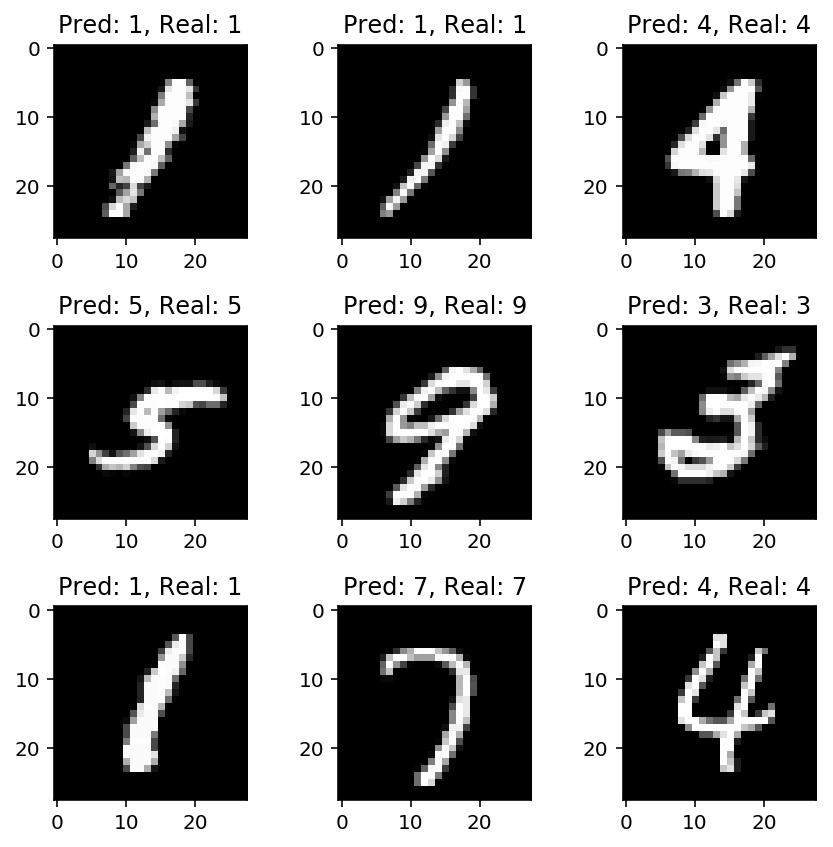

In [36]:
helper.display_nine_random_predictions(predicted_labels, correct, x_test, y_val_test)

### Random incorrect predictions:

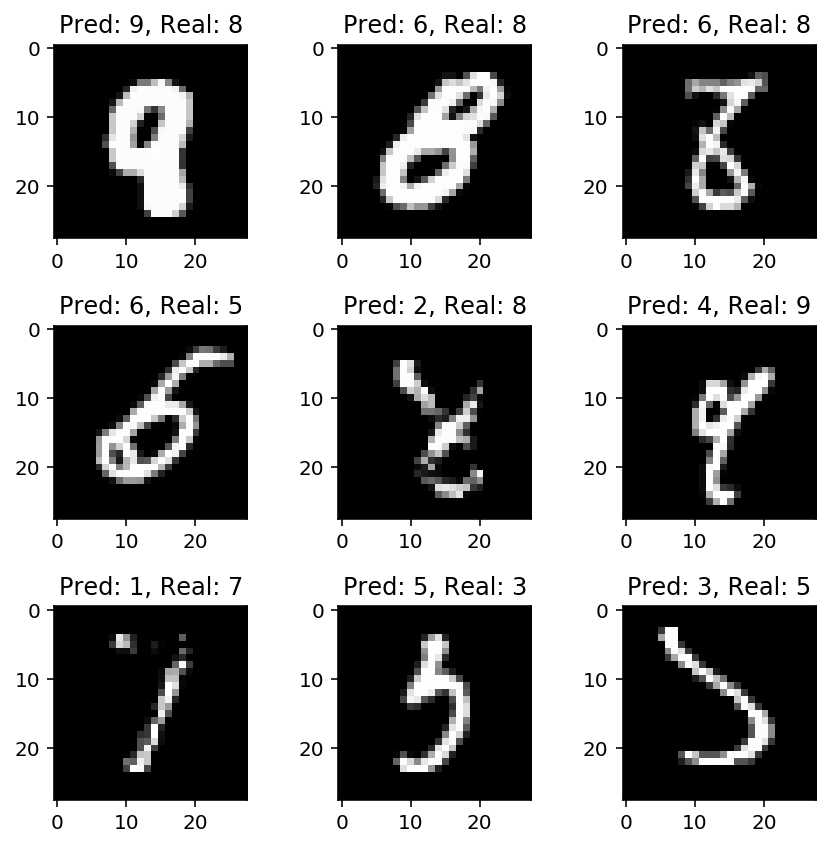

In [37]:
helper.display_nine_random_predictions(predicted_labels, incorrect, x_test, y_val_test)

### Training stats:

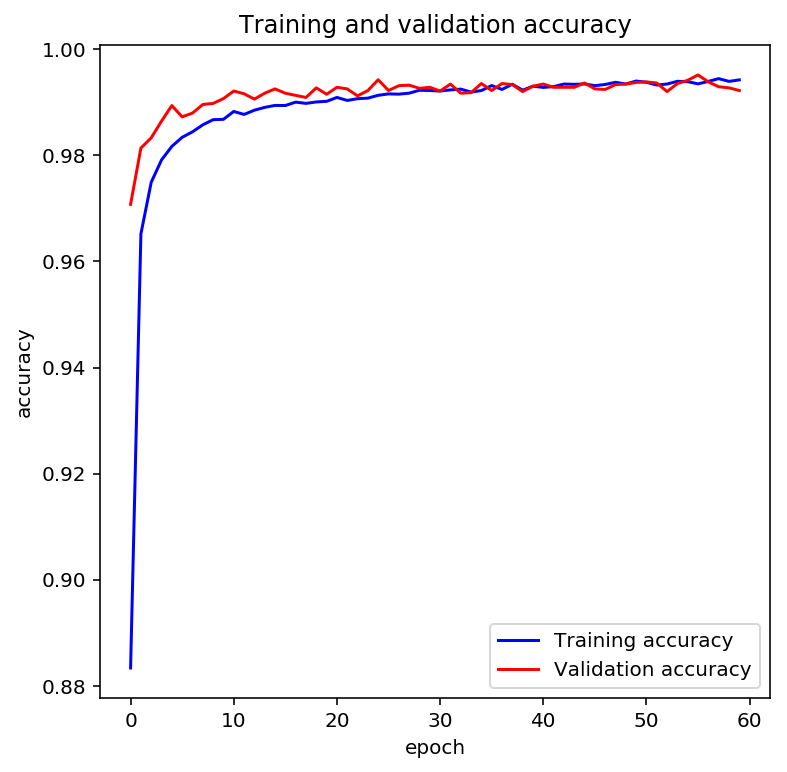

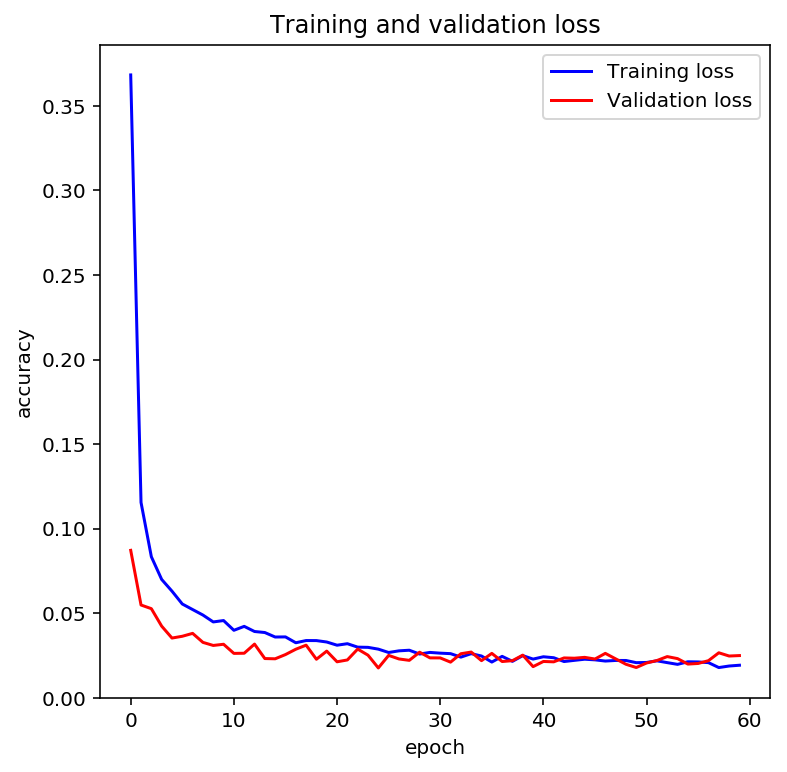

In [38]:
helper.display_accuracy_and_loss(global_history)

### Displaying 4 random wrong predictions with probabilities

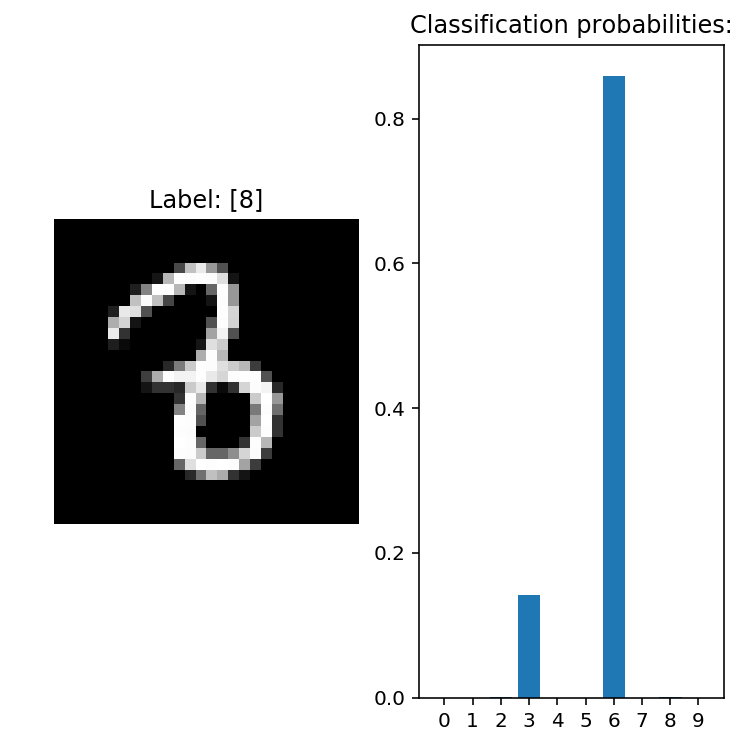

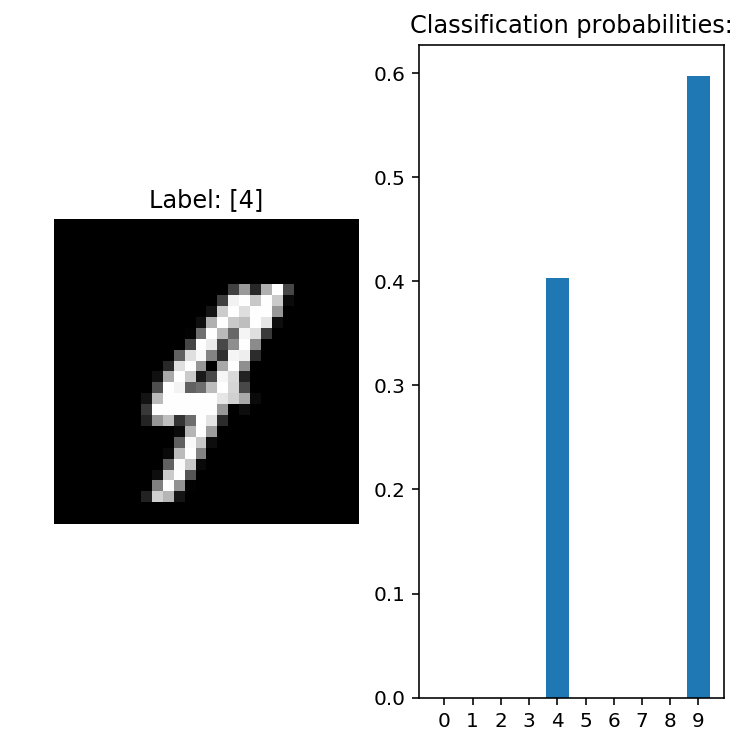

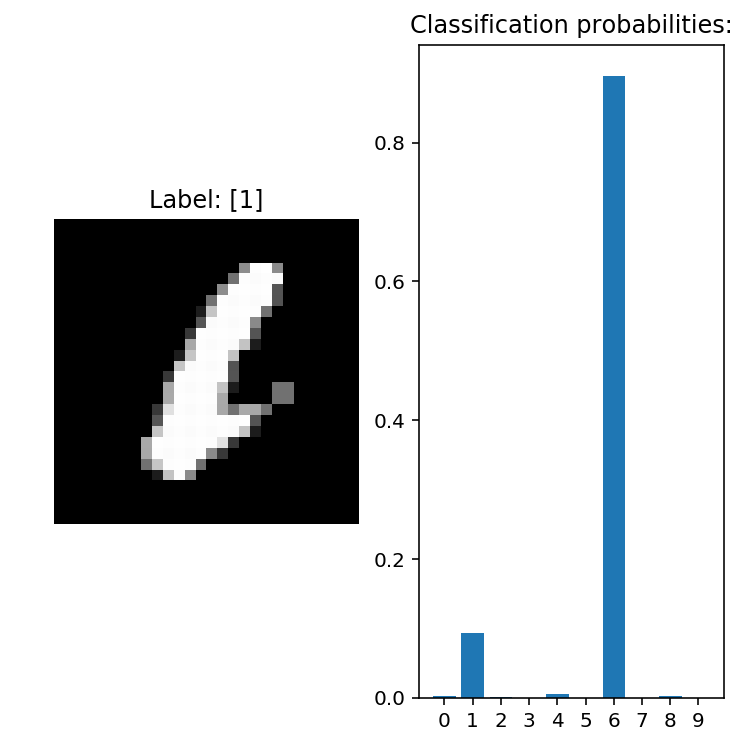

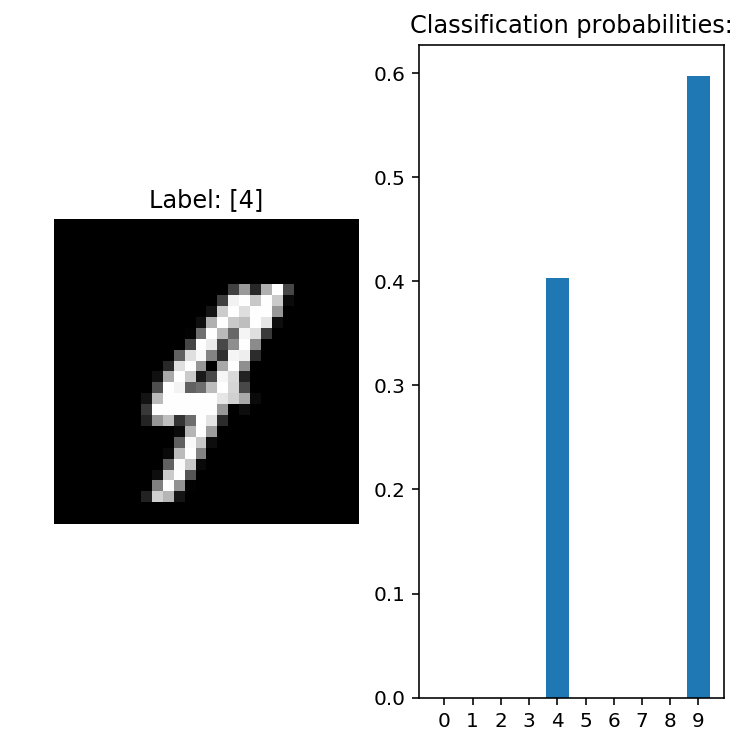

In [39]:
helper.display_incorect_with_probabilities(model, incorrect, x_test, y_val_test, 4)